<a href="https://colab.research.google.com/github/stiflerGit/CAD-Mammography/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# CONSTANTS

IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = 2
BATCH_SIZE    = 64
NUM_EPOCHS    = 150

VERSION = '0.0.01'
# dataset
DATASET_PATH  = '/content/drive/My Drive/CI_FinalProject/'
TRAIN_IMGS_FILE_NAME = 'train_img_%d.npy' % IMAGE_SIZE[0]
TRAIN_LABELS_FILE_NAME = 'train_lab.npy'
TEST_IMGS_FILE_NAME = 'public_test_image_%d.npy' % IMAGE_SIZE[0]
TEST_LABELS_FILE_NAME = 'public_test_label.npy'
# fraction of train dataset used for validation
val_split = 0.2
# model
WORK_PATH = '/content/drive/My Drive/Scratch_CNN/v'+ VERSION
MODEL_NAME = 'model'
MODEL_EXT = '.h5'

In [3]:
from google.colab import drive
import os
drive.mount('/content/drive')

if not os.path.exists(WORK_PATH):
    os.makedirs(WORK_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# PRE-PROCESS DATASET

import numpy as np
from sklearn.model_selection import train_test_split

train_gray_imgs = np.load(os.path.join(DATASET_PATH, TRAIN_IMGS_FILE_NAME))
train_lbls = np.load(os.path.join(DATASET_PATH, TRAIN_LABELS_FILE_NAME))

print(train_lbls.shape) # 2864 images (it is a quite small dataset)
print(np.count_nonzero(train_lbls)) # 1546 
# 1546 images belong to class 1, this means 1318 images belong to class 0
# so our class distribution is good

# we have to equally distribute otherwise the error:
### Training and validation subsets have different number of classes after the 
### split. If your numpy arrays are sorted by the label, you might want to shuffle them.
# could be raised. This is due to the distribution of classes of the labels.
# for example after the split, the training labels set contains both class 1 and 2,
# and on the other hand validation labels set contains either class 1 or class 2.
# Even if the train data would cointain both the classes it's better to equally 
# distribute the two classes over the sets.
X_train, X_val, y_train, y_val = train_test_split(train_gray_imgs, train_lbls,
                                                  test_size=val_split, 
                                                  stratify=train_lbls)

train_samples = len(X_train)
valid_samples = len(X_val)

X_train = 1./32768 * X_train
X_train = X_train - 1.
X_val = 1./32768 * X_val
X_val = X_val - 1.
# this is done to transform the gray imgs into rgb images
X_train = np.stack((X_train,)*3, axis=-1)
X_val = np.stack((X_val,)*3, axis=-1)

del(train_gray_imgs)
del(train_lbls)

test_gray_imgs = np.load(os.path.join(DATASET_PATH, TEST_IMGS_FILE_NAME))
test_gray_imgs =1./32768 * test_gray_imgs
test_gray_imgs = test_gray_imgs - 1.
test_rgb_imgs = np.stack((test_gray_imgs,)*3, axis=-1)
test_lbls = np.load(os.path.join(DATASET_PATH, TEST_LABELS_FILE_NAME))

test_samples=len(test_gray_imgs)

del(test_gray_imgs)

(2864,)
1546


In [6]:
# PRE-PROCESS DATASET 

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15, 
#     zoom_range=[1.5, 0], 
    horizontal_flip=True, vertical_flip=True
)

train_iterator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

test_datagen = ImageDataGenerator()
validation_iterator = test_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)
test_iterator = test_datagen.flow(test_rgb_imgs, test_lbls, batch_size=BATCH_SIZE)

Using TensorFlow backend.


In [7]:

# MODEL DEFINITION

# Deep learning with python - chapter 4.5

from keras import layers
from keras import models
from keras import regularizers

model = models.Sequential()
# LAYER 1
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# LAYER 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# LAYER 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#  LAYER 4
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# LAYER 5
# model.add(layers.Dropout(rate=0.10))
# model.add(layers.Conv2D(512, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
# model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate=0.25))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.25))
# model.add(layers.Dense(1, activation='sigmoid', name='sigmoid')) # for 1,0 output
model.add(layers.Dense(NUM_CLASSES, activation='softmax', name='softmax')) 

################

model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxP

In [8]:
from keras import optimizers
from keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.compile(
    loss='sparse_categorical_crossentropy',
#     loss='binary_crossentropy', # for [0,1] output
    optimizer=optimizers.RMSprop(lr=7e-5),
#     optimizer=optimizers.Adam(lr=7e-5),
    metrics=['acc'])

# model.fit_generator?
history = model.fit_generator(train_iterator, 
                              steps_per_epoch=train_samples // BATCH_SIZE, 
                              epochs=NUM_EPOCHS,
#                               callbacks=[early_stopping],
                              validation_data=validation_iterator,
                              validation_steps=valid_samples // BATCH_SIZE)

Instructions for updating:
Use tf.cast instead.
Epoch 1/150
35/35 [==============================] - 35s 1s/step - loss: 0.6718 - acc: 0.5897 - val_loss: 0.6385 - val_acc: 0.5449
Epoch 2/150
35/35 [==============================] - 34s 965ms/step - loss: 0.6395 - acc: 0.6749 - val_loss: 0.4921 - val_acc: 0.7603
Epoch 3/150
35/35 [==============================] - 30s 857ms/step - loss: 0.5455 - acc: 0.7511 - val_loss: 0.5220 - val_acc: 0.7466
Epoch 4/150
35/35 [==============================] - 31s 884ms/step - loss: 0.5180 - acc: 0.7610 - val_loss: 0.5232 - val_acc: 0.7937
Epoch 5/150
35/35 [==============================] - 31s 883ms/step - loss: 0.4591 - acc: 0.7970 - val_loss: 0.5046 - val_acc: 0.7466
Epoch 6/150
35/35 [==============================] - 31s 885ms/step - loss: 0.4795 - acc: 0.7685 - val_loss: 0.4466 - val_acc: 0.8016
Epoch 7/150
35/35 [==============================] - 31s 887ms/step - loss: 0.4383 - acc: 0.7929 - val_loss: 0.3905 - val_acc: 0.8330
Epoch 8/150
35/35

In [0]:
# from keras.models import Sequential, Model
# from keras import layers

# height = 224
# width = 224

# channels = 3

# num_classes = 2

# model = Sequential()
# model.add(layers.SeparableConv2D(32, 3, activation='relu', input_shape=(height, width, channels,)))
# model.add(layers.SeparableConv2D(64, 3, activation='relu'))
# model.add(layers.MaxPooling2D(2))

# model.add(layers.SeparableConv2D(64, 3, activation='relu'))
# model.add(layers.SeparableConv2D(128, 3, activation='relu'))
# model.add(layers.MaxPooling2D(2))

# model.add(layers.SeparableConv2D(64, 3, activation='relu'))
# model.add(layers.SeparableConv2D(128, 3, activation='relu'))
# model.add(layers.GlobalAveragePooling2D())

# # Dende
# # model.add(layers.Flatten())
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
# save model and history
import numpy as np
net.save(os.path.join(WORK_PATH, MODEL_NAME + MODEL_EXT))
np.save(os.path.join(WORK_PATH,MODEL_NAME,"loss"), np.array(history.history['loss']))
np.save(os.path.join(WORK_PATH,MODEL_NAME,"val_loss"), np.array(history.history['val_loss']))
np.save(os.path.join(WORK_PATH,MODEL_NAME,"acc"), np.array(history.history['acc']))
np.save(os.path.join(WORK_PATH,MODEL_NAME,"val_acc"), np.array(history.history['val_acc']))

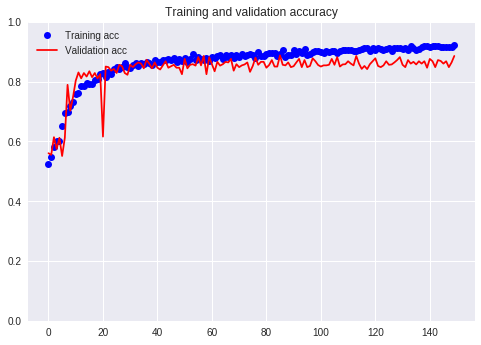

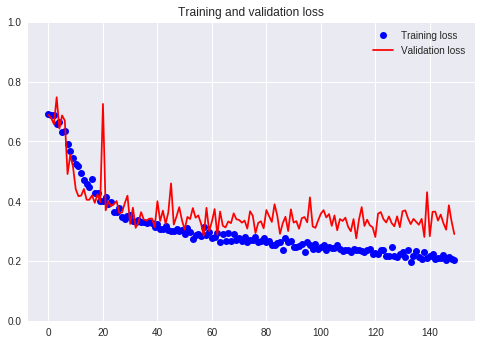

In [0]:
# plot the history
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.ylim((0,1))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.ylim((0,1))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

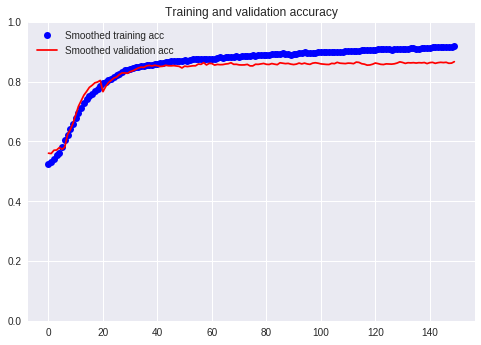

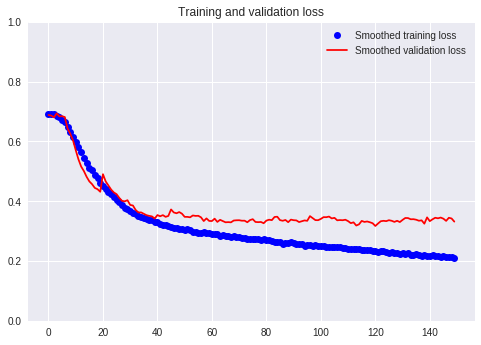

In [0]:
import matplotlib.pyplot as plt


def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.ylim((0,1))
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'r', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.ylim((0,1))
         
plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'r', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
results = model.evaluate_generator(test_iterator, steps=test_samples//BATCH_SIZE, verbose=1)

print("test_loss: ", results[0], " test_acc: ", results[1])

5/5 [==============================] - 1s 225ms/step
test_loss:  0.40991954803466796  test_acc:  0.875
